# Field Development using Decline Curve & Finding Optimum Number of Wells
---------------------
~Apoorva Saxena
---------------------

## Table of contents
* Data
* Decline Curve Analysis
* Economic Analysis (Maximum Number of wells)

# Data

I will be using single set of data, containing all the production data of the well in the vincity.

####  Permian Basin - Data Dump

About this file

- Well Name: Name of the wells within Permian Basin
- Prod Date: Production Date
- Monthly Oil Volume: Monthly cumulative oil
- Well Spacing: Well spacing, ft
- Fluid bb/ft: Fluid in barrels pumped per feet
- Proppants lbs/ft: Proppants in pounds pumped per feet

## Importing Libraries

In [11]:
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np # library to handle data in a vectorized manner


# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt

# backend for rendering plots within the browser
%matplotlib inline 
%config InlineBackend.figure_format = "svg"

from datetime import datetime

from scipy.optimize import curve_fit

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA

import pmdarima as pm

import ipywidgets

print('Libraries imported')

Libraries imported


#### Next, we will import Permian Basin - Data Dump file

In [2]:
df_Permian = pd.read_excel(r"C:\Users\apoor\Desktop\Matt - Tall City\Permian_Basin_Data Dump.xlsx", header=0)

# Let us visualize the first 5 rows of the dataframe
df_Permian.head()

,Well Name,Prod Date,Monthly Oil Volumes,"Well Spacing, ft",Fluid bb/ft,Proppant lbs/ft
0,Juggernaut,2021-01-01,12545.894960,1043.49,68.397212,3457.549049
1,Juggernaut,2021-02-28,23550.457169,1043.49,68.397212,3457.549049
2,Juggernaut,2021-03-31,33206.903943,1043.49,68.397212,3457.549049
3,Juggernaut,2021-04-30,44284.133100,1043.49,68.397212,3457.549049
4,Juggernaut,2021-05-31,51640.976921,1043.49,68.397212,3457.549049


#### Data Pre-Processing

Let us filter df_Permian dataframe and We will only be using Beast well data since it's the closest to the ABC Corporation Lease. 

In [3]:
df_Beast = df_Permian[df_Permian['Well Name']=='Beast']

---------------------

# Decline Curve Analysis

Once we have pre-processed our data, we will perform decline curve analysis on Beast well

#### Define Functions
Let us define some functions that will help us perform decline curve analysis

In [4]:
def hyperbolic_equation(t, qi, b, di):
    """
    Hyperbolic decline curve equation
    
    Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        b: Float. Hyperbolic decline constant
        di: Float. Nominal decline rate at time t=0
        
    Output: 
        Returns q, or the expected production rate at time t. Float.
    """
    return qi/((1.0+b*di*t)**(1.0/b))

def exponential_equation(t, qi, di):
    """
    Exponential decline curve equation
    
    Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        di: Float. Nominal decline rate (constant)
        
    Output: 
        Returns q, or the expected production rate at time t. Float.
    """
    return qi*np.exp(-di*t)

def get_max_initial_production(df, number_first_months, variable_column, date_column):
    """
    This function allows you to look at the first X months of production, and selects 
    the highest production month as max initial production
    
    Arguments:
        df: Pandas dataframe. 
        number_first_months: float. Number of months from the point the well comes online
        to compare to get the max initial production rate qi (this looks at multiple months
        in case there is a production ramp-up)
        variable_column: String. Column name for the column where we're attempting to get
        the max volume from (can be either 'Gas' or 'Oil' in this script)
        date_column: String. Column name for the date that the data was taken at 
    """
    #First, sort the data frame from earliest to most recent prod date
    df=df.sort_values(by=date_column)
    
    #Pull out the first x months of production, where number_first_months is x
    df_beginning_production=df.head(number_first_months)
    
    #Return the max value in the selected variable column from the newly created 
    #df_beginning_production df
    return df_beginning_production[variable_column].max()

def Convert_DailyDecline_to_MonthlyDecline(qi,daily_decline):
    """
    This function converts daily decline rate 
    to monthly
    
    Arguments:
        qi: Float. Initial flow rate (B/D or SCF/D or B/M or SCF/M) 
            calculated from max_initial_production function
            or initial production rate when well first came online
        daily_decline: Float. Exponential or nominal decline rate 
            (in days).
            
    Output: 
        Monthly decline rate. Float.
    """
    return np.log(qi/(qi*np.exp(-daily_decline*30.417)))

def EUR_Time(model,qi,q_limit,b,declineRate):
    """
    This function calculates Economic Ultimate Recovery and time
    
    Arguments:
        model: String. Hyperbolic or Exponential
        qi: Float. Initial flow rate (B/D or SCF/D or B/M or SCF/M) 
            calculated from max_initial_production function
            or initial production rate when well first came online
        q_limit: Float. Economic limit production rate (B/D or SCF/D)
        b: Float. Hyperbolic Exponent
        declineRate: Float. Exponential or nominal decline rate 
            (in days, months, year so long as they are consistent).
            
    Output: 
        Returns EUR (Barrels or SCF) 
        and time (in days, months, year 
        so long as they are consistent). Float.
    """
    if model == 'Exponential':
        return (qi-q_limit)/declineRate, round(np.log(qi/q_limit)/declineRate)
    elif model == 'Hyperbolic':
        num = (qi**b)*((qi**(1-b))-(q_limit**(1-b)))
        den = (1-b)*declineRate
        return num/den
    else:
        print('Incorrect Model Name')

def Forecast_DeclineRate(model,qi,q_limit,b,declineRate_Daily):
    """
    This function forecasts monthly cumulative production and calculates 
    time in months.
    
    Arguments:
        model: String. Hyperbolic or Exponential
        qi: Float. Initial flow rate (B/D or SCF/D or B/M or SCF/M) 
            calculated from max_initial_production function
            or initial production rate when well first came online
        q_limit: Float. Economic limit production rate (B/D or SCF/D or 
                B/M or SCF/M)
        b: Float. Hyperbolic Exponent
        declineRate: Float. Exponential or nominal decline rate (in days).
            
    Output: 
        Returns a dataframe with time in months, oil rate 
        per month and cumulative production for every month.
    """
    d_PerMonth = Convert_DailyDecline_to_MonthlyDecline(qi,declineRate_Daily)
    time = [] # Time in months
    q_calc = [] # Rate in BBLS per day or per month
    Np = [] # Monthly Cumulative oil production in BBLS
    
    if model == 'Exponential':
        for i in np.arange(EUR_Time(model,qi,q_limit,b,d_PerMonth)[1]):
            q = qi * np.exp(-d_PerMonth*i)
            Np_calc = 30.417*((qi - q)/d_PerMonth)

            if q >= q_limit:
                time.append(i+1)
                q_calc.append(q)
                Np.append(Np_calc)

            else:
                break
                
    return pd.DataFrame({'Time_Month':time, 'OilRate_BBL_Month':q_calc,'Cumulative_Oil_BBL':Np})

#### Performing Decline Curve Analysis

Let's take Beast dataframe and create a copy to Well_Data and visualize first five rows of the dataframe

In [5]:
Well_Data = df_Beast.copy()
Well_Data.head()

,Well Name,Prod Date,Monthly Oil Volumes,"Well Spacing, ft",Fluid bb/ft,Proppant lbs/ft
162,Beast,2021-01-01,11268.712902,523.725,70.961317,3388.189688
163,Beast,2021-02-28,19783.701439,523.725,70.961317,3388.189688
164,Beast,2021-03-31,26394.345873,523.725,70.961317,3388.189688
165,Beast,2021-04-30,32914.151816,523.725,70.961317,3388.189688
166,Beast,2021-05-31,40444.966695,523.725,70.961317,3388.189688


We shall perform data cleaning on this data set

In [6]:
# Perform some data cleaning to get the columns as the right data type
Well_Data['Prod Date']=pd.to_datetime(Well_Data['Prod Date'])

# Dropping columns
Well_Data = Well_Data.drop(columns=['Well Spacing, ft','Fluid bb/ft','Proppant lbs/ft'])

#Renaming Columns
Well_Data = Well_Data.rename(columns={"Well Name": "Well_Name", 
                                      'Prod Date': 'Prod_Date',
                                     'Monthly Oil Volumes':'Monthly_OilVolumes_BBL'})

#Declare the desired product that we want to curve fit for--it can either by 'Gas' or 'Oil'
desired_product_type='Monthly_OilVolumes_BBL'

#Remove all rows with null values in the desired time series column
Well_Data = Well_Data[(Well_Data[desired_product_type].notnull()) & (Well_Data[desired_product_type]>0)]
Well_Data=Well_Data[(Well_Data['Prod_Date'].notnull())].reset_index(drop=True)


#Generate column for time online delta
Well_Data['Days_Online']=(Well_Data['Prod_Date']-Well_Data['Prod_Date'][0]).dt.days

Let's visualize the first 5 dataset

In [7]:
Well_Data.head()

,Well_Name,Prod_Date,Monthly_OilVolumes_BBL,Days_Online
0,Beast,2021-01-01,11268.712902,0
1,Beast,2021-02-28,19783.701439,58
2,Beast,2021-03-31,26394.345873,89
3,Beast,2021-04-30,32914.151816,119
4,Beast,2021-05-31,40444.966695,150


#### Curve fitting

Once the data has been processed, we will move towards curve fitting

In [8]:
production_time_series=Well_Data

# Get the highest value of production, to use as qi value
total_days = production_time_series.Prod_Date.count()
qi=get_max_initial_production(production_time_series, total_days, desired_product_type, 'Prod_Date')

# Exponential curve fit the data to get best fit equation
popt_exp, pcov_exp=curve_fit(exponential_equation, production_time_series['Days_Online'], 
                             production_time_series[desired_product_type],bounds=(0, [qi,0.1]))
print('Exponential Fit Curve-fitted Variables: qi='+str(popt_exp[0])+', Nominal Decline per day (di)='+str(popt_exp[1]))

# Hyperbolic curve fit the data to get best fit equation
popt_hyp, pcov_hyp=curve_fit(hyperbolic_equation, production_time_series['Days_Online'], 
                             production_time_series[desired_product_type],bounds=(0, [qi,2,20]))
print('Hyperbolic Fit Curve-fitted Variables: qi='+str(popt_hyp[0])+', b='+str(popt_hyp[1])+', Decline per day (di)='+str(popt_hyp[2]))

# Exponential fit results
production_time_series.loc[:,'Exponential_Predicted']=exponential_equation(production_time_series['Days_Online'], 
                          *popt_exp)
# Hyperbolic fit results
production_time_series.loc[:,'Hyperbolic_Predicted']=hyperbolic_equation(production_time_series['Days_Online'], 
                          *popt_hyp)
production_time_series.loc[:,'Hyperbolic_Predicted']=hyperbolic_equation(production_time_series['Days_Online'], 
                          50417.69,(1.919*10**-10),0.00157)

Exponential Fit Curve-fitted Variables: qi=35787.636742218165, Nominal Decline per day (di)=0.0019484088539942915
Hyperbolic Fit Curve-fitted Variables: qi=35778.36444607826, b=1.7966090344709504e-16, Decline per day (di)=0.0019466271863687148


##### For Exponential Fit we got qi (max initial production) = 35787 BBL/Month and nominal decline per day = 0.0019
##### For Hyperbolic Fit we got qi (max initial production) = 35778 BBL/Month, b = 1.79e-16 and daily decline rate = 0.0019

#### Plotting the data to visualize the equation fit

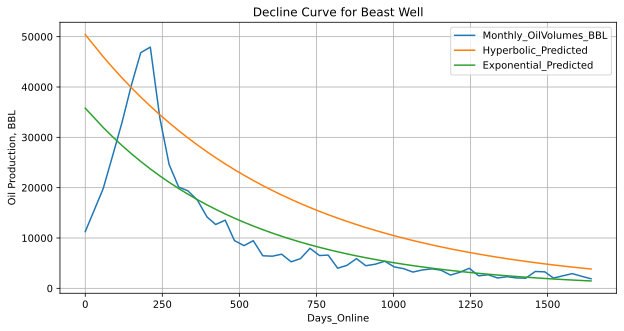

In [9]:
# Declare the x- and y- variables that we want to plot against each other

y_variables=[desired_product_type, "Hyperbolic_Predicted", "Exponential_Predicted"]
x_variable='Days_Online'

# Figure Size
fig_size=(10,5)

# Create the plot title
plot_title='Decline Curve for Beast Well'

# Plot the data to visualize the equation fit
production_time_series.plot(x=x_variable, y=y_variables, title=plot_title,figsize=fig_size, grid=True)
plt.ylabel('Oil Production, BBL')
# plt.savefig('Decline Curve for Beast Well.jpeg',dpi=200,quality=95,optimize=True)
plt.show()

#### We can clearly see from the plot that Hyperbolic Curve will give you good fit. Let's see what is our EUR for Magneto Well. We will use the function 'EUR_Time' to get the results. Let us assume economic limit to be 30 BBL/Month

In [10]:
oil_ecn = 30 # STB/Month
monthly_decline = Convert_DailyDecline_to_MonthlyDecline(popt_exp[0],popt_exp[1])

print('EUR = {} MSTB. It will take {} months to reach economic rate of {} STB/Month'.format(round(EUR_Time('Exponential',popt_exp[0],oil_ecn,0,monthly_decline)[0]/1000),round(EUR_Time('Exponential',popt_exp[0],oil_ecn,0,monthly_decline)[1]),oil_ecn))

# Remaining Reserves
remaining_reserves = EUR_Time('Exponential',popt_exp[0],oil_ecn,0,monthly_decline)[0] - production_time_series.Monthly_OilVolumes_BBL[production_time_series.shape[0]-1]
print(round(remaining_reserves/1000),'MSTB')

EUR = 603 MSTB. It will take 120 months to reach economic rate of 30 STB/Month
601 MSTB


##### EUR = 603 MSTB. It will take 120 months to reach economic rate of 30 STB/Month. Remaining recoverable reserves are 601 MSTB.

##### Let us next plot the decline curve upto the economic limit

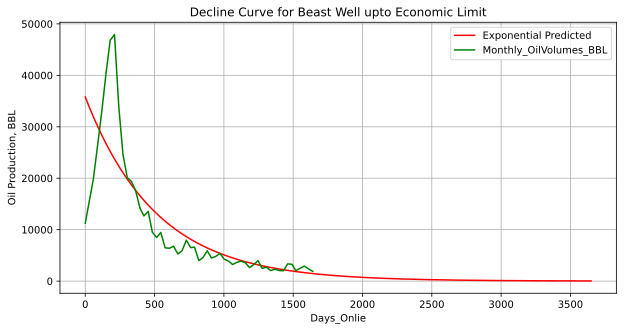

In [11]:
#Plot the fitted function

days = range(round(EUR_Time('Exponential',popt_exp[0],oil_ecn,0,monthly_decline)[1]*30.4167))
y_exp_pred = exponential_equation(days, *popt_exp)

plt.figure(figsize = (10,5)) # Figure Size

plt.plot(days, y_exp_pred, color='red', label='Exponential Predicted')
plt.plot(production_time_series.Days_Online, production_time_series.Monthly_OilVolumes_BBL, 'g', label='Monthly_OilVolumes_BBL')
plt.grid()
plt.title('Decline Curve for Beast Well upto Economic Limit')
plt.xlabel('Days_Onlie')
plt.ylabel('Oil Production, BBL')
plt.legend()
# plt.savefig('Decline Curve EUR for Beast Well.jpeg',dpi=200,quality=95,optimize=True)
plt.show()

#### Let's get the Forecasted results and pre-process the data.

We will forecast the data using the function Forecast_Decline which we had defined earlier

In [12]:
df_DCA_MonthlyForecast = Forecast_DeclineRate('Exponential',popt_exp[0],oil_ecn,0,popt_exp[1])

In [13]:
# Adding gas and water production to our forecast dataframe. We have fixed our GOR and WOR at 3MSCF/BBL and 70% respectively

df_DCA_MonthlyForecast['GasProduction_MSCF'] = df_DCA_MonthlyForecast['OilRate_BBL_Month']*3
df_DCA_MonthlyForecast['WaterProduction_BBLS'] = df_DCA_MonthlyForecast['OilRate_BBL_Month']*(0.7/(1-0.4))

# Let us visualize the first 5 rows of forecast data
df_DCA_MonthlyForecast.head()

,Time_Month,OilRate_BBL_Month,Cumulative_Oil_BBL,GasProduction_MSCF,WaterProduction_BBLS
0,1,35787.636742,0.000000e+00,107362.910227,41752.242866
1,2,33728.316584,1.056924e+06,101184.949751,39349.702681
2,3,31787.495435,2.053030e+06,95362.486305,37085.411341
3,4,29958.354534,2.991817e+06,89875.063601,34951.413622
4,5,28234.467487,3.876583e+06,84703.402461,32940.212068


Since our forecasted data is in months, we will convert it into years

In [14]:
# Exracting data at every 12th month
df_DCA_YearlyForecast = df_DCA_MonthlyForecast[df_DCA_MonthlyForecast['Time_Month']%12==0].reset_index(drop=True)

# Renaming Columns
df_DCA_YearlyForecast = df_DCA_YearlyForecast.rename(columns={'Time_Month':'Time_Years',
                                                      'OilRate_BBL_Month':'OilRate_BBL_Year'
                                                     })
# Converting Time from months to year
df_DCA_YearlyForecast['Time_Years'] = df_DCA_YearlyForecast['Time_Years']/12
df_DCA_YearlyForecast['Time_Years'] = df_DCA_YearlyForecast['Time_Years'].astype('int32')

# Visualize the dataframe
df_DCA_YearlyForecast

# Exporting Forecasting dataframe to excel
# df_DCA_YearlyForecast.to_excel('DCA_Forecast_Results.xlsx',index=None)

,Time_Years,OilRate_BBL_Year,Cumulative_Oil_BBL,GasProduction_MSCF,WaterProduction_BBLS
0,1,18647.092170,8.797201e+06,55941.276511,21754.940865
1,2,9156.950357,1.366791e+07,27470.851071,10683.108750
2,3,4496.665704,1.605976e+07,13489.997112,5246.109988
3,4,2208.159012,1.723431e+07,6624.477036,2576.185514
4,5,1084.351505,1.781109e+07,3253.054514,1265.076755
5,6,532.488004,1.809433e+07,1597.464013,621.236005
6,7,261.486680,1.823342e+07,784.460040,305.067793
7,8,128.407181,1.830172e+07,385.221544,149.808378
8,9,63.056383,1.833526e+07,189.169149,73.565780
9,10,30.964837,1.835173e+07,92.894511,36.125643


#### There, you saw how we calculated EUR for Beast well. The same concept can be applied for any given wells and we will get the EUR for that respective wells.

---------------------

# Finding Optimum Number of Wells

#### Let us find the optimum number of wells required

We will create a function which will give us the optimum number of wells for greater NPV returns

In [15]:
def Optimum_wells(time,intrest_rate,C,V,q,Np,Z,show_plot=False,save_fig=False):
    """
    Calculates and plots optimum number of wells
    
    Arguments:
        time: String. monthly or yearly
        intrest_rate: Percentage. Interest rate or discount rate
        (annually)
        C: Float. Drilling/Completion costs
        V: Float. Price of oil($) or gas($)
        q: Float. Given oil rate(BOPD)
        Np: Float. Total cumulative production
        Z: Float. the present value of other investments not
        dependent on the number of wells after income
        tax’s effect ($)
        save_fig: Boolean. Save the plot if set True. Default is False
        show_plot: Boolean. Show the plot if set True. Default is False
        
    Output: 
        Returns a tuple consisting of number of optimum wells and
        maximum NPV. If set True for save plot or show plot will 
        show and save plot respectively.
    """
    W = np.zeros(300)
    NPV = np.zeros(300)
    
    if time == 'yearly':
        time = 365
        intrest_rate = intrest_rate/(100)
        
    elif time == 'monthly':
        time = 30
        intrest_rate = intrest_rate/(time*100)
               
    for i in range(300):
        W[i] = i
        npv = (time*W[i]*q*V) / [(time*W[i]*q/(Np))+np.log(1+intrest_rate)] - (C*W[i]) - Z
        NPV[i] = npv

    df = pd.DataFrame()
    df['Wells'] = W
    df['NPV'] = NPV
    
    if show_plot == True:
        plt.figure(figsize=(10,5))
        plt.plot(df.Wells,df.NPV)
        plt.axvline(x=df[df['NPV']==df.NPV.max()].iloc[0,0], linestyle='--', color='grey')
        plt.title('NPV vs Number of Wells')
        plt.xlabel('Number of Wells\nOptimum Number of Wells={}'.format(str(int(df[df['NPV']==df.NPV.max()].iloc[0,0]))))
        plt.ylabel('NPV($)')
        if save_fig == True:
            plt.savefig('NPV vs Number of Wells.jpeg',dpi=200,quality=95,optimize=True)
        plt.show()
        
    return df[df['NPV']==df.NPV.max()].iloc[0,0] , round(df.NPV.max())

Let us see with the given economic parameters, what is our maximum optimum number of wells

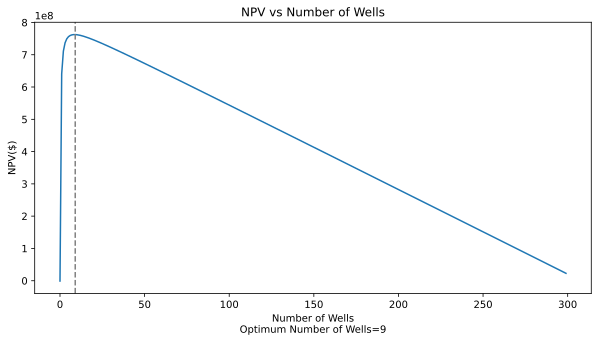

In [16]:
max_well,max_Npv = Optimum_wells('yearly',
                    intrest_rate=20, 
                    C=2325000+300000, 
                    V=42+2.11, q=popt_exp[0], 
                    Np=df_DCA_YearlyForecast['Cumulative_Oil_BBL'].max(), 
                    Z=1000000,show_plot=True,save_fig=False)

# Closing Remarks

NPV calculations has been done on the excel. All in all, I hope I was able to convey my thought process in the form of this particular exercise.